In [9]:
import pandas as pd
from price_impact.modelling.Futures import FutureContract, Spot
from price_impact import tick_base_dir, data_dir

from pathlib import Path 

import os
from zipfile import ZipFile
import datetime as dt
import warnings

import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

PLOT_FOLDER = Path("./plots")


plt.style.use('bmh')

In [10]:
def resample(data):
    df = data.copy()
    
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format="%m/%d/%Y %H:%M:%S.%f")
    df = df.set_index('datetime').drop(columns=['date','time'])
    df_res = df.resample('15min').sum()
    df_res['time'] = df_res.index.time

    return df_res

def clean_label(label):
    return ' '.join(label.split('_')).title()

### Effect of netting and binning volume

ES
NQ
CL
GL


C:\ProgramData\Anaconda3\Temp\ipykernel_31296\3261930447.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(minor=True), minor=True, rotation=45, ha='right')


TU
GC


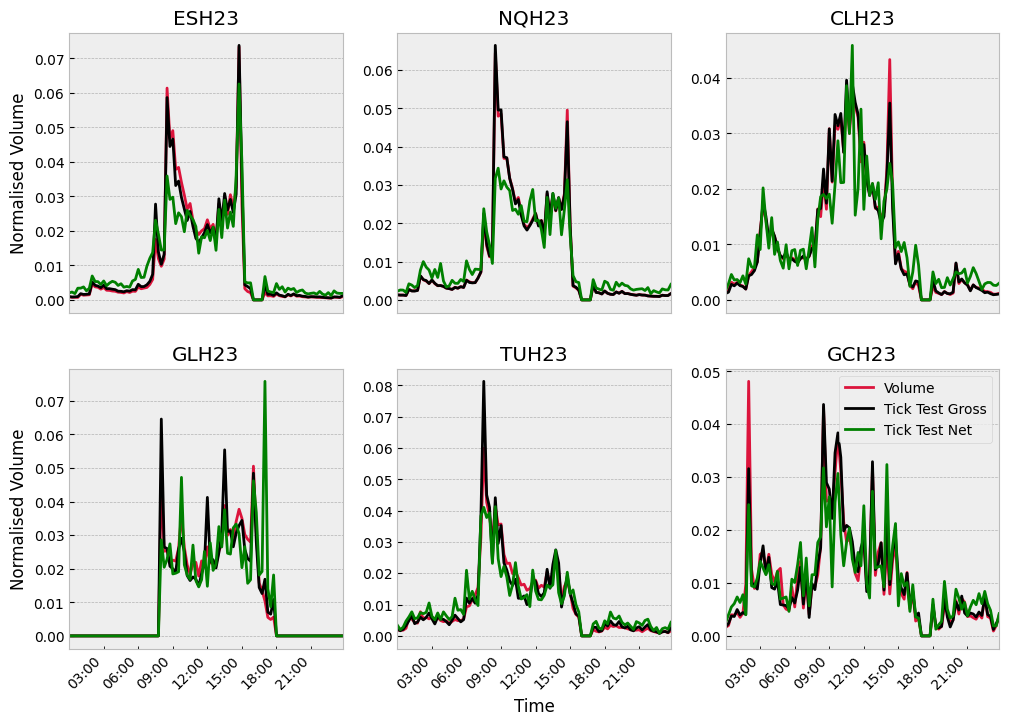

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
vols = {}

for idx, spot in enumerate(['ES', 'NQ', 'CL', 'GL', 'TU', 'GC']):
    fp = f'./data/{spot}_tick_test.pickle'
    print(spot)

    if os.path.exists(fp):
        plot_df = pd.read_pickle(fp)

    else:

        file = tick_base_dir / spot[0] / spot / f"2023_02_{spot}.zip"
        df_list = []
        with ZipFile(file, 'r') as zf:
            for filename in zf.namelist():
                if not filename[:5] == f'{spot}H23':
                    continue
                with zf.open(filename) as f:
                    df_list.append(pd.read_csv(f, compression='gzip', header=None, low_memory=False))

        df = pd.concat(df_list)
        df.columns = ['date', 'time', 'price', 'volume', 'market_flag', 'sales_condition', 'exclude_flag', 'unfiltered_price']
        df = df[df['exclude_flag'].isna()]
        df = df[df['price'] != 0]

        df = df.sort_values(by=['date', 'time'])

        vols[spot] = {'base': df['volume'].sum()}

        df['prev_price'] = df['price'].shift()
        df = df.assign(price_mult=lambda x: 1)

        df.loc[df['price'] == df['prev_price'], 'price_mult'] = 0
        df['tick_test_gross'] = df['volume']*df['price_mult']

        df.loc[df['price'] < df['prev_price'], 'price_mult'] = -1
        df['tick_test_net'] = df['volume']*df['price_mult']

        vols[spot]['tt'] = df['tick_test_net'].abs().sum()

        df = df[['date', 'time', 'volume', 'tick_test_gross', 'tick_test_net']]

        res = resample(df)
        res.index = pd.to_datetime(res['time'].astype('str'), format="%H:%M:%S")
        res = res.drop(columns='time').sort_index()

        plot_df = res.abs().groupby('time').sum()

        vols[spot]['tt_agg'] = plot_df['tick_test_net'].abs().sum()

        plot_df = plot_df.divide(plot_df.sum(axis=0))

        plot_df.to_pickle(fp)

    i, j = idx//3, idx % 3

    ax = axs[i][j]
    ax = plot_df.plot(ax=ax, color=['crimson', 'k', 'g'])

    # ax.legend(['Pre tick test', 'Post tick test'])
    ax.set_xticks([])
    ax.set_xlabel(None)
    if idx == 4:
        ax.set_xlabel('Time')

    if not i:
        ax.set_xticks([], minor=True)
    else:
        ax.set_xticklabels(ax.get_xticklabels(minor=True), minor=True, rotation=45, ha='right')

    if not j:
        ax.set_ylabel('Normalised Volume')

    ax.set_title(f"{spot}H23")
    ax.get_legend().remove()

ax.legend(list(map(clean_label, plot_df.columns)), fontsize=10)

fig.savefig(PLOT_FOLDER/'data'/'volume_netting.png')

### Volume trends of different futures rolls

In [15]:
def get_future_volume_df(future, num_to_lookback):
    files = os.listdir(bin_path/future.spot)
    files = list(filter(lambda x: 'vol' in x, files))

    files = sorted(files, key=lambda x: (int(x[3:5]), x[2]))

    fut_idx = files.index(f"{future}_vol.pkl")+1
    files = files[fut_idx-num_to_lookback:fut_idx][::-1]

    dfs = []
    for file in files:
        dfs.append(pd.read_pickle(bin_path/future.spot/file))

    dfs = [df.abs().sum(axis=1) for df in dfs]

    df = pd.concat(dfs, axis=1)
    df.columns = [FutureContract(file.split('_')[0]) for file in files]
    
    return df

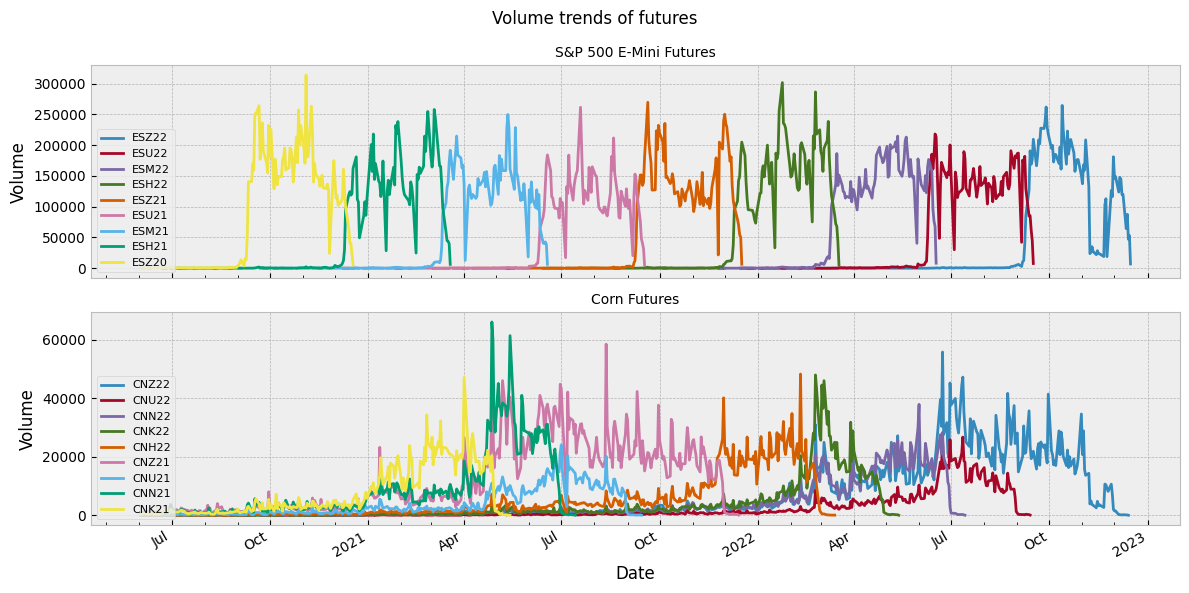

: 

In [25]:
bin_path = data_dir / "bins" / "10s"

fig, axs = plt.subplots(2, figsize=(12, 6), sharex=True)

for idx, future in enumerate(['ESZ22', 'CNZ22']):
    plt.gca().set_prop_cycle(None)

    future = FutureContract(future)
    df = get_future_volume_df(future, num_to_lookback=9)
    df = df[df.index > '2020-06-01']

    (1+df).plot(ax=axs[idx], logy=False)
    axs[idx].legend(ncols=1, loc=3, fontsize=8)

    ax = axs[idx]
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.set_ylabel('Volume')
    ax.set_title(future.spot.description, fontsize=10)
    

ax.set_xlabel('Date')
fig.suptitle('Volume trends of futures')
fig.tight_layout()
fig.savefig(PLOT_FOLDER/'data'/'futures_roll.png')

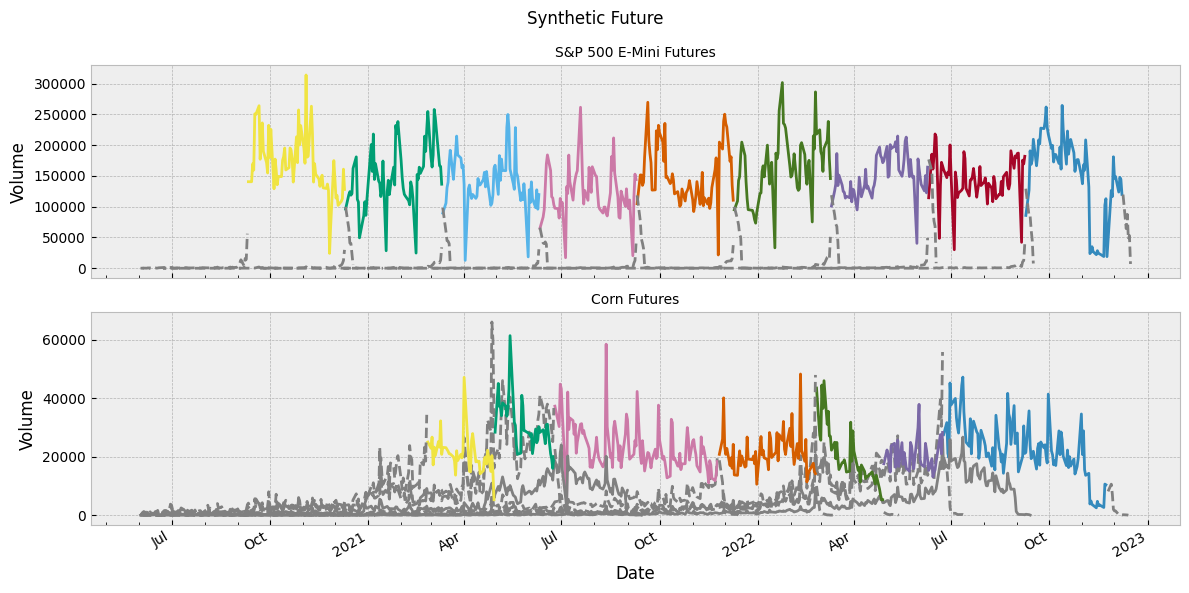

In [22]:
bin_path = data_dir / "bins" / "10s"

fig, axs = plt.subplots(2, figsize=(12, 6), sharex=True)


for idx, future in enumerate(['ESZ22', 'CNZ22' ]):
    
    future = FutureContract(future)
    df = get_future_volume_df(future, num_to_lookback=9)
    df = df[df.index > '2020-06-01']
    ax: plt.Axes = axs[idx]
    ax.set_prop_cycle(None)
    train_end = future.backtest_end_date
    
    for future in df.columns:
        if future.expiry_month_str in future.active_months:
            train_start = future.previous_contract().backtest_end_date
            
            in_df = df.copy()
            out_df = df.copy()
            
            in_mask = (df.index>=train_start)&(df.index< train_end)
            in_df[~in_mask] = None
            out_df[in_mask] = None
            
            in_df[future].plot(ax=ax)
            out_df[future].plot(ax=ax, color='gray', linestyle='--')
            
            train_end = train_start
        
        else:
            ax.plot(df[future], color='gray')
            next(ax._get_lines.prop_cycler)

    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.set_ylabel('Volume')
    ax.set_title(future.spot.description, fontsize=10)

ax.set_xlabel('Date')
fig.suptitle('Synthetic Future')
fig.tight_layout()
fig.savefig(PLOT_FOLDER/'data'/'futures_roll_synthetic.png')

### Smoothing

In [23]:
bin_path = data_dir / 'synthetic' / 'bins'/'10s'

ticker = 'ES'
sma_len = 20

px_df = pd.read_pickle(bin_path/f'{ticker}_px.pkl')
vol_df = pd.read_pickle(bin_path/f'{ticker}_vol.pkl')
smoothed_df =  pd.read_pickle(data_dir/'daily'/ f'{ticker}_daily_sma{sma_len}.pkl')

vol_df = vol_df.abs().sum(axis=1)
px_df = px_df.pct_change(axis=1).std(axis=1)


start_date = '2016-01-01'
vol_df = vol_df[vol_df.index>=start_date]
px_df = px_df[px_df.index>=start_date]
smoothed_df = smoothed_df[smoothed_df.index>=start_date]

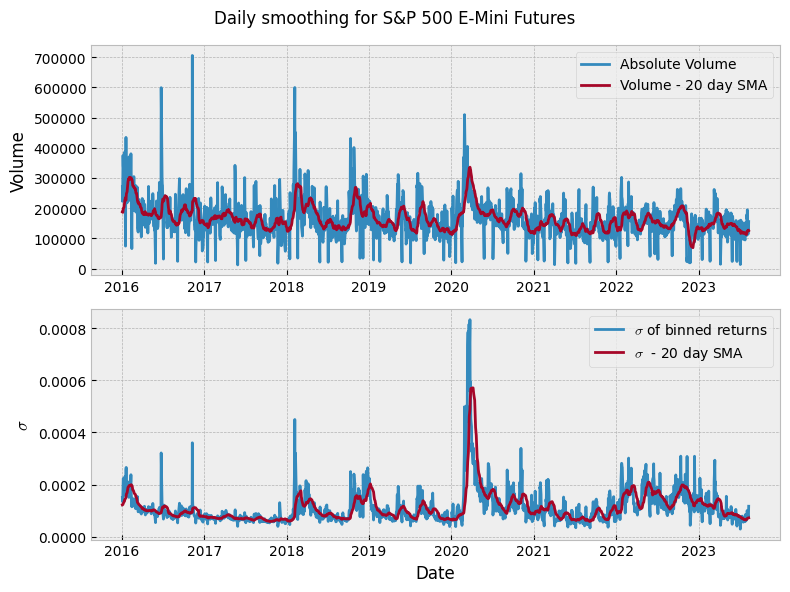

In [24]:
fig, axs = plt.subplots(2, figsize=(8,6))
ax1, ax2 = axs

ax1.plot(vol_df, label='Absolute Volume')
ax1.plot(smoothed_df['volume'], label=f"Volume - {sma_len} day SMA")

ax2.plot(px_df, label=r'$\sigma$ of binned returns')
ax2.plot(smoothed_df['stdev'], label=fr"$\sigma$  - {sma_len} day SMA")

ax1.legend()
ax2.legend()

ax2.set_xlabel('Date')
ax1.set_ylabel('Volume')
ax2.set_ylabel(r'$\sigma$')

fig.suptitle(f'Daily smoothing for {Spot(ticker).description}')
fig.tight_layout()

fig.savefig(PLOT_FOLDER/'data'/'smoothing.png')